In [28]:
import pickle
import sys

import matplotlib.pyplot as plt
import pandas as pd
from river.decomposition import OnlineDMD

sys.path.append("../")

from functions.chdsubid import (
    SubIDChangeDetector,
    DMDOptSubIDChangeDetector,
    get_default_params,
)  # noqa: E402
from functions.rolling import Rolling  # noqa: E402
from functions.preprocessing import Hankelizer  # noqa: E402
from functions.datasets import load_skab  # noqa: E402
from functions.metrics import chp_score  # noqa: E402

In [29]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [30]:
# Read data
dfs = load_skab("data/skab")
dfs_free = [
    df
    for key, df_group in dfs.items()
    for df in df_group
    if key == "anomaly-free"
]
dfs_: list[pd.DataFrame] = [
    pd.DataFrame(df)
    for key, df_group in dfs.items()
    for df in df_group
    if key != "anomaly-free"
]
for df in dfs_:
    df.index = pd.to_datetime(df.index)

In [355]:
# Prepare arrays for storing results
scores_datasets = []
predicted_outlier, predicted_cp = [], []
true_outlier, true_cp = [], []

grace_period = 400  # Used in SKAB Leaderboard

# Iterate datasets
for i, df in enumerate(dfs_):
    print(f"Processing dataset {i+1}/{len(dfs_)}", end="\r")
    Y = df[["anomaly", "changepoint"]]
    X = df.drop(["anomaly", "changepoint"], axis=1)
    from sklearn.model_selection import train_test_split

    X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, train_size=grace_period, shuffle=False
    )

    window_size, hn, ref_size, test_size, r = get_default_params(
        X, grace_period // 2
    )  # Anomalies take 5 minutes sampling is 1 second
    window_size = grace_period
    hn = 30
    r = 2
    ref_size = 200
    test_size = 300
    # Initialize Hankelizer
    hankelizer = Hankelizer(hn)

    # Initialize Transformer
    init_size = window_size
    odmd = Rolling(
        OnlineDMD(
            r=r,
            initialize=init_size,
            w=1.0,
            exponential_weighting=False,
            eig_rtol=1e-1,
        ),
        init_size + 1,
    )

    # Initialize Change-Point Detector
    subid_dmd = SubIDChangeDetector(
        odmd,
        ref_size=ref_size,
        test_size=test_size,
        grace_period=grace_period,
        threshold=0.001,  # df.std().mean() / 100,
        learn_after_grace=False,
    )

    # Build pipeline
    pipeline_dmd = hankelizer | subid_dmd

    scores_dmd = []
    predictions = []
    pipeline_dmd.learn_many(X_train)

    # Run pipeline
    for j, x in enumerate(X_test.to_dict(orient="records")):
        if (j + 1) % 1000 == 0:
            print(f"\rProcessed {j + 1}/{len(X)} {' ':<80}", end="\r")
        pipeline_dmd.learn_one(x)

        # if j >= grace_period:
        scores_dmd.append(subid_dmd.score)
        predictions.append(subid_dmd._drift_detected)
        # else:
        #     scores_dmd.append(0)
        #     predictions.append(0)

    prediction = (
        pd.Series(predictions, index=X_test.index)
        .astype(int)
        .rolling(30)
        .max()
        .fillna(0)
    )

    scores_datasets.append(pd.Series(scores_dmd, index=X_test.index))
    predicted_outlier.append(prediction)
    prediction_cp = prediction.diff().abs()
    prediction_cp.iloc[0] = prediction.iloc[0]
    predicted_cp.append(prediction_cp)

    true_outlier.append(Y_test["anomaly"])
    true_cp.append(Y_test["changepoint"])

with open("results/.skab/skab_scores_datasets-online.pkl", "wb") as f:
    pickle.dump(scores_datasets, f)

In [304]:
true_outlier, true_cp = [], []
# Iterate datasets
for i, df in enumerate(dfs_):
    Y = df[["anomaly", "changepoint"]]
    from sklearn.model_selection import train_test_split

    Y_train, Y_test = train_test_split(
        Y, train_size=grace_period, shuffle=False
    )
    true_outlier.append(Y_test["anomaly"])
    true_cp.append(Y_test["changepoint"])
# with open("results/.skab/skab_scores_datasets-online.pkl", "rb") as f:
#     scores_datasets = pickle.load(f)

In [356]:
pos = []
for sd in scores_datasets:
    pos.append(
        ((sd > 0.001).astype(int).astype(int).rolling(30).max().fillna(0))
    )

pcs = []
for prediction in pos:
    pc = prediction.diff().abs()
    pc.iloc[0] = prediction.iloc[0]
    pcs.append(pc)

In [357]:
# [donotremove]
binary = chp_score(true_outlier, pos, metric="binary")

False Alarm Rate 44.15 %
Missing Alarm Rate 39.71 %
F1 metric 0.61


In [358]:
# [donotremove]
# average detection delay metric calculation
add = chp_score(
    true_cp,
    pcs,
    metric="average_time",
    anomaly_window_destination="righter",
    portion=1,
)

Since you didn't choose window_width and portion, portion will be default (1)
Amount of true anomalies 127
A number of missed CPs = 73
A number of FPs = 56
Average time 0 days 00:01:02.711111111


In [363]:
# [donotremove]
# nab metric calculation
nab = chp_score(
    true_cp,
    pcs,
    metric="nab",
    window_width="60s",
    anomaly_window_destination="righter",
)

Standard  -  13.46
LowFP  -  8.87
LowFN  -  16.59


# Visualize results

In [361]:
def plot_results(
    *true_pred_pairs: tuple[pd.Series, pd.Series], reset_index: bool = False
):
    n = len(true_pred_pairs)
    fig, axs = plt.subplots(n, 1, figsize=(12, 3 * n))

    for ax, (true, pred) in zip(axs, true_pred_pairs):
        if reset_index:
            true = true.reset_index(drop=True)
            pred = pred.reset_index(drop=True)
        ax.plot(true, label="True", marker="o", markersize=5)
        axx = ax.twinx()
        axx.plot(
            pred,
            label="Predicted",
            marker="x",
            markersize=5,
            color=ax._get_lines.get_next_color(),
        )
        ax.grid()

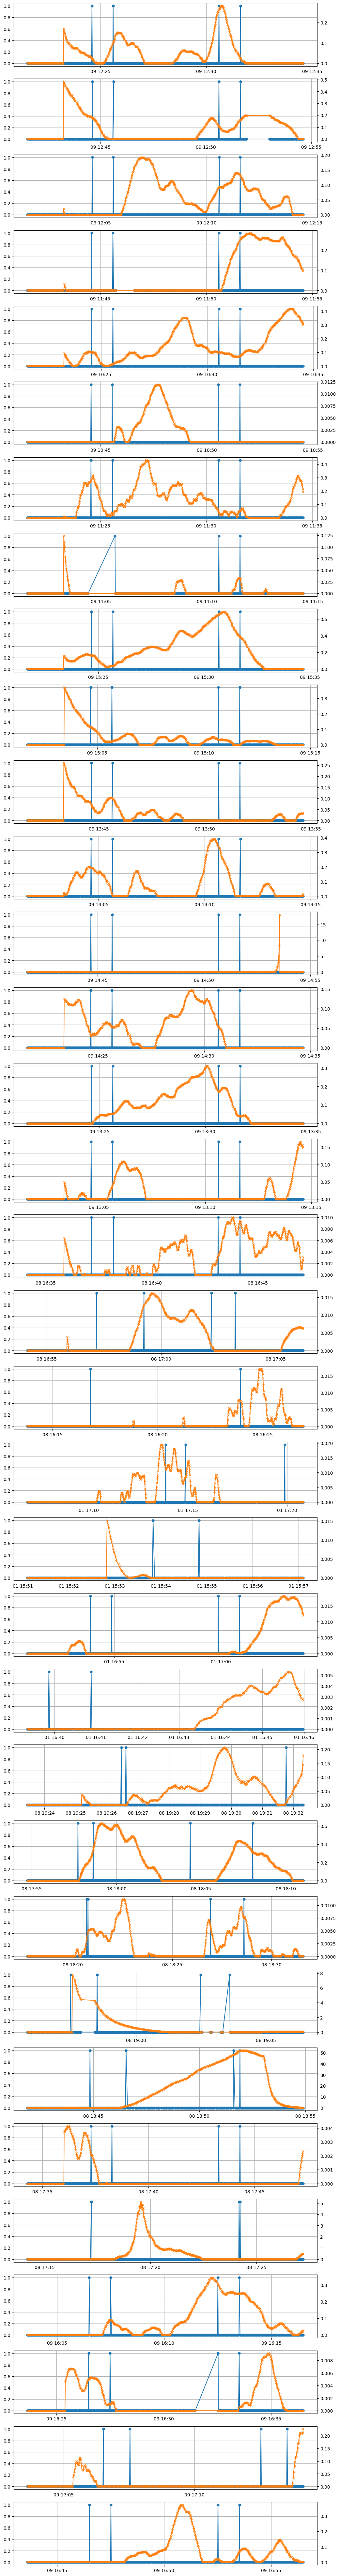

In [362]:
# [donotremove]
plot_results(*list(zip(*(true_cp, scores_datasets))))